In [1]:
!pip install transformers datasets torch


Defaulting to user installation because normal site-packages is not writeable


In [2]:
import torch
from transformers import DistilBertTokenizer, DistilBertForQuestionAnswering, Trainer, TrainingArguments
from datasets import Dataset
import pandas as pd
from torch.utils.data import Dataset as TorchDataset

2024-09-13 13:44:40.875302: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-13 13:44:40.911479: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-13 13:44:40.921990: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-13 13:44:40.943110: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-13 13:44:42.929429: W tensorflow/compiler/tf2

In [3]:
 # Load your custom dataset from CSV
df = pd.read_csv("/home/dnn/Storage8TB/pythonCodeArea/srijita/Text/summary.csv")
dataset = Dataset.from_pandas(df)


In [4]:
from datasets import Dataset, DatasetDict
# Split the dataset into train and test (80% train, 20% test)
train_test_split = dataset.train_test_split(test_size=0.2)

# Further split the test set into validation and test (50% of the test set for validation)
test_valid_split = train_test_split['test'].train_test_split(test_size=0.5)

# Combine the train, test, and validation splits into a DatasetDict
text = DatasetDict({
    'train': train_test_split['train'],
    'test': test_valid_split['test'],
    'validation': test_valid_split['train']  # This part is validation
})

# Verify the structure of the split
print(text)

DatasetDict({
    train: Dataset({
        features: ['Paragraph', 'Summary'],
        num_rows: 48
    })
    test: Dataset({
        features: ['Paragraph', 'Summary'],
        num_rows: 6
    })
    validation: Dataset({
        features: ['Paragraph', 'Summary'],
        num_rows: 6
    })
})


In [5]:
text['train'][0]

{'Paragraph': 'The global spread of smartphones has improved access to the internet, transforming industries such as banking and retail, but also raising concerns about digital addiction and data security.',
 'Summary': 'Smartphones have enhanced internet access, boosting industries but creating issues like addiction and security risks.'}

array([[<AxesSubplot: title={'center': 'Paragraph Length'}>,
        <AxesSubplot: title={'center': 'Summary Length'}>]], dtype=object)

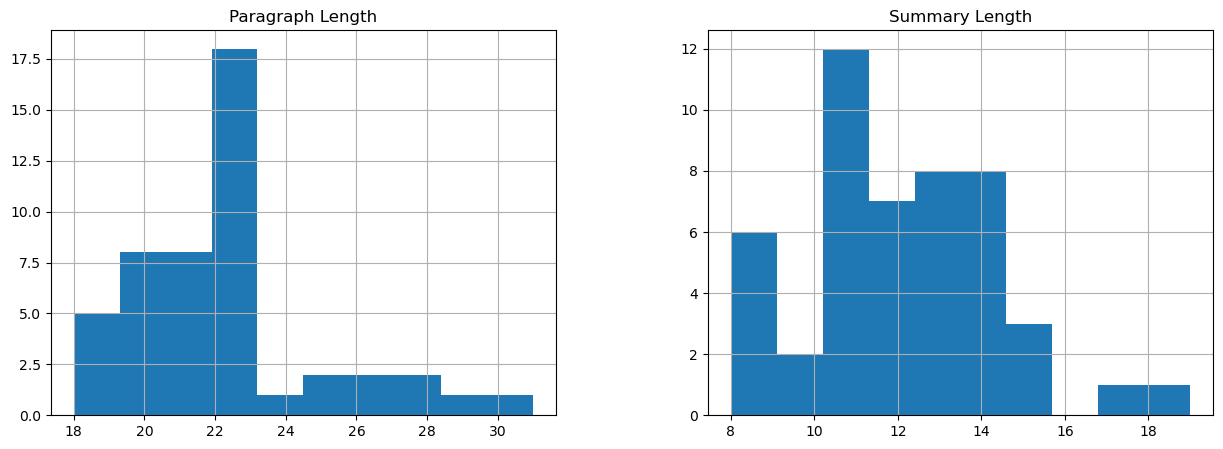

In [6]:
paragraph_len = [len(x['Paragraph'].split()) for x in text['train']]
summary_len = [len(x['Summary'].split()) for x in text['train']]

data = pd.DataFrame([paragraph_len, summary_len]).T
data.columns = ['Paragraph Length', 'Summary Length']

data.hist(figsize=(15,5))

In [7]:

# Custom Dataset class to handle labels
class CustomDataset(TorchDataset):
    def __init__(self, encodings, summary_labels):
        self.encodings = encodings
        self.summary_labels = summary_labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(self.encodings[key][idx]) for key in self.encodings}
        item['labels'] = torch.tensor(self.summary_labels[idx])
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

In [8]:
# Custom Data Collator
class CustomDataCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def __call__(self, features):
        batch = {key: torch.stack([f[key] for f in features]) for key in features[0].keys()}
        return batch


In [9]:
# Load the model and tokenizer for BART
def load_model_and_tokenizer():
    model = BartForConditionalGeneration.from_pretrained("sshleifer/distilbart-cnn-12-6")
    tokenizer = BartTokenizer.from_pretrained("sshleifer/distilbart-cnn-12-6")
    if torch.cuda.is_available():
        model = model.to("cuda")
    return model, tokenizer

In [10]:
# Preprocess the dataset
def preprocess_function(examples, tokenizer):
    inputs = examples['Paragraph']
    summaries = examples['Summary']
    
    model_inputs = tokenizer(inputs, max_length=256, truncation=True, padding="max_length")
    
    with tokenizer.as_target_tokenizer():
        summary_labels = tokenizer(summaries, max_length=128, truncation=True, padding="max_length")

    summary_labels['input_ids'] = [[-100 if token == tokenizer.pad_token_id else token for token in label] for label in summary_labels['input_ids']]

    return {
        'input_ids': model_inputs['input_ids'],
        'attention_mask': model_inputs['attention_mask'],
        'summary_labels': summary_labels['input_ids'],
    }

In [11]:
# Train the model with user-defined parameters
def train_model(model, tokenizer, train_dataset, valid_dataset, epochs, batch_size, learning_rate):
    training_args = TrainingArguments(
        output_dir="./results",
        evaluation_strategy="epoch",
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epochs,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=10,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=valid_dataset,
        tokenizer=tokenizer,
        data_collator=CustomDataCollator(tokenizer),
    )

    trainer.train()

In [12]:
# Function to generate summaries based on user input
def generate_summary(text, model, tokenizer):
    inputs = tokenizer(text, return_tensors="pt", max_length=512, truncation=True)
    
    # Move inputs to GPU if available
    if torch.cuda.is_available():
        inputs = {key: value.to("cuda") for key, value in inputs.items()}
    
    # Generate the summary
    summary_ids = model.generate(
        input_ids=inputs["input_ids"], 
        max_new_tokens=64,  # Set the number of tokens you want to generate
        num_beams=4, 
        early_stopping=True
    )
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    
    return summary

In [13]:
if __name__ == "__main__":
    model, tokenizer = load_model_and_tokenizer()

   
    # Split into training and validation datasets (80/20 split)
    train_test_split = dataset.train_test_split(test_size=0.2)
    train_dataset = train_test_split['train']
    valid_dataset = train_test_split['test']

    # Preprocess dataset
    processed_train_data = train_dataset.map(lambda x: preprocess_function(x, tokenizer), batched=True)
    processed_valid_data = valid_dataset.map(lambda x: preprocess_function(x, tokenizer), batched=True)

    # Create TorchDataset objects
    train_torch_dataset = CustomDataset(
        encodings={k: processed_train_data[k] for k in ['input_ids', 'attention_mask']},
        summary_labels=processed_train_data['summary_labels'],
    )
    valid_torch_dataset = CustomDataset(
        encodings={k: processed_valid_data[k] for k in ['input_ids', 'attention_mask']},
        summary_labels=processed_valid_data['summary_labels'],
    )

   


/home/dnn/.local/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/home/dnn/.local/lib/python3.12/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


Map:   0%|          | 0/48 [00:00<?, ? examples/s]

/home/dnn/.local/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:4126: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/12 [00:00<?, ? examples/s]

In [14]:
 # User input for training parameters
epochs = 50
batch_size = 8
learning_rate = 2e-5

# Train the model based on user input
train_model(model, tokenizer, train_torch_dataset, valid_torch_dataset, epochs, batch_size, learning_rate)

/home/dnn/.local/lib/python3.12/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: srijitaghoshhajra9 (srijitaghoshhajra9-college-board). Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,No log,1.865040
2,No log,1.594086
3,No log,1.486001
4,1.698000,1.304623
5,1.698000,1.295690
6,1.698000,1.274675
7,0.556700,1.344797
8,0.556700,1.486190
9,0.556700,1.617099
10,0.226000,1.699501


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


In [18]:

# Get a new text input from the user for summarization
text = "I find embroidery making very interesting. It is my hobby. I spend some time on it every day. It is very refreshing and relaxing for me to engage in my hobby.I play with designs and colours. I can use different types of cloth to make embroidery on. I can choose many different colours of thread to make embroidery with. The patters I choose are also varied. I have made embroidered apparel and have always been excited to make a new item. Embroidery making is however time-consuming.I have made many interesting items of embroidery. I have made a chocolate cake embroidery on a table cloth. It looks like a real birthday cake. I also embroidered sparrows on a stole. I love the sparrow but do not see it now-a-days on my verandah. My friends like my stole because they too miss the sparrow.I am very fond of making embroidery on my mother’s sarees. My mother buys sarees on which I embroider small flowers, leaves and butterflies. My mother loves to drape these sarees. Embroidery can make designs alive in a very beautiful and colourful way. A plain apparel can become a fashion garment if it is embroidered tastefully."

# Generate the summary for the user-provided text
summary = generate_summary(text, model, tokenizer)
print(f"\nGenerated Summary:\n{summary}")



Generated Summary:
Embroidery is my hobby and I spend some time on it every day. I love the sparrow but do not see it now-a-days on my verandah. I am very fond of making embroidery on my mother's sarees.


In [17]:

# Get a new text input from the user for summarization
text = "The tower is 324 metres (1,063 ft) tall, about the same height as an 81-storey building, and the tallest structure in Paris. Its base is square, measuring 125 metres (410 ft) on each side. During its construction, the Eiffel Tower surpassed the Washington Monument to become the tallest man-made structure in the world, a title it held for 41 years until the Chrysler Building in New York City was finished in 1930. It was the first structure to reach a height of 300 metres. Due to the addition of a broadcasting aerial at the top of the tower in 1957, it is now taller than the Chrysler Building by 5.2 metres (17 ft). Excluding transmitters, the Eiffel Tower is the second tallest free-standing structure in France after the Millau Viaduct."

# Generate the summary for the user-provided text
summary = generate_summary(text, model, tokenizer)
print(f"\nGenerated Summary:\n{summary}")


Generated Summary:
The Eiffel Tower is 324 metres (1,063 ft) tall, about the same height as an 81-storey building, and is the tallest structure in Paris. It is now taller than the Chrysler Building in New York City by 5.2 metres (17 ft)
